In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *
from bnbsl import *

from classes import *
from utils import *

In [3]:
SEASON = '23'
set_seed(int(SEASON))

## Download HKJC odds

In [4]:
path_raw = Path('raw_data')
path_data = Path('data')

path_output = Path('output')

In [5]:
session = requests.Session()
r = session.get('http://bet.hkjc.com')
cookies = r.cookies

In [6]:
odds_url = 'https://bet.hkjc.com/football/getJSON.aspx?jsontype=odds_chl.aspx'
response = session.post(
    odds_url,
    headers={'referer':'http://bet.hkjc.com'},
    cookies=cookies
)

In [7]:
with open(path_data/'json'/f'odds_chl-{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}.txt', 'w') as f:
    f.write(response.text)

In [8]:
matches_json = json.loads(response.text)['matches']

In [9]:
# Example
# matches_json = json.loads(open(path_data/'json'/'odds_chl-2021-11-20-20-15-14.txt').read())[1]['matches']

In [10]:
matches = [Match(m) for m in matches_json if m['matchStatus'] == 'Defined']
odds = [m.export() for m in matches]

['20240517FRIFB6462', '2024-May-17', '23:00:00', 'Finnish Division 1 [FVL]', 'AC Oulu', 'IFK Mariehamn', 'true', '10.5', '2.13', '1.63', 'false', '11.5', '2.68', '1.40', 'false', '13.5', '4.60', '1.14']
['20240517FRIFB6461', '2024-May-17', '23:00:00', 'Finnish Division 1 [FVL]', 'HJK Helsinki', 'VPS Vaasa', 'true', '11.5', '2.15', '1.62', 'false', '12.5', '2.68', '1.40', 'false', '14.5', '4.40', '1.15']
['20240518SATFB6465', '2024-May-18', '00:00:00', 'Finnish Division 1 [FVL]', 'SJK Seinajoki', 'Inter Turku', 'true', '9.5', '1.81', '1.89', 'false', '10.5', '2.29', '1.55', 'false', '13.5', '4.75', '1.13']
['20240518SATFB6460', '2024-May-18', '01:00:00', 'Finnish Division 1 [FVL]', 'Ilves', 'Haka', 'true', '10.5', '1.97', '1.74', 'false', '11.5', '2.50', '1.46', 'false', '14.5', '4.95', '1.12']
['20240518SATFB6468', '2024-May-18', '01:45:00', 'Portuguese Premier [PFL]', 'Famalicao', 'Casa Pia AC', 'true', '10.5', '2.04', '1.69', 'false', '11.5', '2.60', '1.43', 'false', '13.5', '4.05', 

In [11]:
cols_match = ['MatchDay', 'Date', 'Time', 'LeagueJC', 'HomeTeamJC', 'AwayTeamJC']
cols_odds0 = ['MAINLINE_0', 'CHL_LINE_0', 'CHL_H_0', 'CHL_L_0']
cols_odds1 = ['MAINLINE_1', 'CHL_LINE_1', 'CHL_H_1', 'CHL_L_1']
cols_odds2 = ['MAINLINE_2', 'CHL_LINE_2', 'CHL_H_2', 'CHL_L_2']
cols_odds  = ['MAINLINE', 'CHL_LINE', 'CHL_H', 'CHL_L']
cols_pred  = ['alpha_1', 'alpha_2', 'mu_1', 'mu_2', 'omega', 'corr']

cols = cols_match + cols_odds0 + cols_odds1 + cols_odds2

In [12]:
odds = [o for o in odds if len(o) == 18]

In [13]:
odds = pd.DataFrame(odds, columns=cols)
odds = odds.fillna(value=np.nan)

In [14]:
cols_odds_ = cols_odds0[1:]+cols_odds1[1:]+cols_odds2[1:]
odds[cols_odds_] = odds[cols_odds_].astype(float)

In [15]:
odds

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE_0,CHL_LINE_0,CHL_H_0,CHL_L_0,MAINLINE_1,CHL_LINE_1,CHL_H_1,CHL_L_1,MAINLINE_2,CHL_LINE_2,CHL_H_2,CHL_L_2
0,20240517FRIFB6462,2024-May-17,23:00:00,Finnish Division 1 [FVL],AC Oulu,IFK Mariehamn,true,10.5,2.13,1.63,false,11.5,2.68,1.40,false,13.5,4.60,1.14
1,20240517FRIFB6461,2024-May-17,23:00:00,Finnish Division 1 [FVL],HJK Helsinki,VPS Vaasa,true,11.5,2.15,1.62,false,12.5,2.68,1.40,false,14.5,4.40,1.15
2,20240518SATFB6465,2024-May-18,00:00:00,Finnish Division 1 [FVL],SJK Seinajoki,Inter Turku,true,9.5,1.81,1.89,false,10.5,2.29,1.55,false,13.5,4.75,1.13
3,20240518SATFB6460,2024-May-18,01:00:00,Finnish Division 1 [FVL],Ilves,Haka,true,10.5,1.97,1.74,false,11.5,2.50,1.46,false,14.5,4.95,1.12
4,20240518SATFB6468,2024-May-18,01:45:00,Portuguese Premier [PFL],Famalicao,Casa Pia AC,true,10.5,2.04,1.69,false,11.5,2.60,1.43,false,13.5,4.05,1.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,20240521TUEFB6638,2024-May-21,01:00:00,Russian Premier [RPL],FC Nizhny Novgorod,CSKA Moscow,true,10.5,2.15,1.62,false,11.5,2.68,1.40,false,13.5,4.60,1.14
127,20240521TUEFB6626,2024-May-21,02:30:00,Spanish Division 2 [SF2],Villarreal B,Albacete,true,9.5,2.05,1.68,false,10.5,2.62,1.42,false,12.5,4.60,1.14
128,20240521TUEFB6593,2024-May-21,02:30:00,Spanish Division 2 [SF2],Espanyol,Oviedo,true,10.5,2.20,1.59,false,11.5,2.75,1.38,false,13.5,4.60,1.14
129,20240521TUEFB6615,2024-May-21,06:00:00,Argentine Division 1 [APL],San Lorenzo,Lanus,true,9.5,2.08,1.66,false,10.5,2.68,1.40,false,12.5,4.60,1.14


In [16]:
odds['MatchDay'] = odds['MatchDay'].str[8:]
odds['Date'] = pd.to_datetime(odds['Date'])
odds['Time'] = pd.to_datetime(odds['Time'], format='%H:%M:%S').dt.time

In [17]:
odds['DateTimeJC'] = pd.to_datetime(odds['Date'].dt.date.map(str) + '-' + odds['Time'].map(str))
odds['DateTimeJC'] = odds['DateTimeJC'].dt.tz_localize('Hongkong')
odds['DateTime'] = odds['DateTimeJC'].dt.tz_convert('GB')

In [18]:
map_league = pd.read_csv(path_data/'league.csv')
map_team = pd.read_csv(path_data/'team.csv')

In [19]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2', 'UCL', 'UEC', 'UEF', 'EFA', 'SFC']
map_league = map_league[map_league.Div.isin(div)].reset_index(drop=True)

In [20]:
# Map Div name
odds = odds.merge(map_league[['LeagueJC', 'Div']], 'inner', on='LeagueJC')

In [21]:
# Map Team name
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'HomeTeam'}), 'inner', 
                  left_on='HomeTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'AwayTeam'}), 'inner', 
                  left_on='AwayTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])

## Download recent stats

In [22]:
# Download latest results in current season
!wget -q https://www.football-data.co.uk/mmz4281/{SEASON}{int(SEASON)+1}/data.zip -O raw_data/data.zip

# Unzip to folder
!unzip -q -o raw_data/data.zip -d raw_data/{SEASON}

In [23]:
usecols = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'HC', 'AC', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST']
dtype = {'HC':'float', 'AC':'float'}
parse_dates = ['Date']

seasons = [SEASON]

dfs = []

for folder in sorted(path_raw.iterdir()):
    if folder.is_dir() and folder.name in seasons: 
        for file in sorted(folder.glob('*.csv')):
            try:
                df = pd.read_csv(file, usecols=usecols, dtype=dtype, parse_dates=parse_dates, dayfirst=True)
                df['Season'] = folder.name
                dfs.append(df)
            except:
                continue

In [24]:
df_season = pd.concat(dfs)
df_season = df_season.dropna()
df_season = df_season.sort_values(['Div', 'Date', 'HomeTeam']).reset_index(drop=True)

In [25]:
df_hist = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])
df_hist = df_hist.query(f'Season == {int(SEASON)-1}').reset_index(drop=True)

In [26]:
df_season = pd.concat([df_hist[df_season.columns], df_season])

In [27]:
# Make features on historical stats (Home and Away)
stats = ['FTHG', 'HS', 'HST', 'HC', 'FTAG', 'AS', 'AST', 'AC']
df_home, df_away = joinLastGamesStatsHomeAway(df_season, stats)

In [28]:
# Make features on historical stats (For and Against)
stats = [('FTHG', 'FTAG', 'FTG'), ('HS', 'AS', 'S'), ('HST', 'AST', 'ST'), ('HC', 'AC', 'C')]
df_for, df_against = joinLastGamesStatsForAgainst(df_season, stats)

In [29]:
df_home = df_home.sort_values(['HomeTeam', 'Date']).reset_index(drop=True)
df_away = df_away.sort_values(['AwayTeam', 'Date']).reset_index(drop=True)

df_home = df_home.groupby('HomeTeam')[df_home.columns[df_home.columns.str.contains('Avg')]].last().reset_index()
df_away = df_away.groupby('AwayTeam')[df_away.columns[df_away.columns.str.contains('Avg')]].last().reset_index()

In [30]:
odds = odds.merge(df_home, 'left', 'HomeTeam').merge(df_away, 'left', 'AwayTeam')

In [31]:
cols_home = df_for.columns[df_for.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_for.columns[df_for.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_for = df_for.groupby('Team')[df_for.columns[df_for.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_for.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_for.rename(columns=cols_away), 'left', 'AwayTeam')

In [32]:
cols_home = df_against.columns[df_against.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_against.columns[df_against.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_against = df_against.groupby('Team')[df_against.columns[df_against.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_against.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_against.rename(columns=cols_away), 'left', 'AwayTeam')

In [33]:
add_datepart(odds, 'DateTime', prefix='', drop=False);

In [34]:
display_df(odds.head(5).T)

,0,1,2,3,4
MatchDay,SATFB6470,SATFB6589,SATFB6585,SUNFB6587,SUNFB6586
Date,2024-05-18 00:00:00,2024-05-18 00:00:00,2024-05-18 00:00:00,2024-05-19 00:00:00,2024-05-19 00:00:00
Time,02:30:00,22:15:00,22:15:00,03:00:00,20:00:00
LeagueJC,Spanish Division 2 [SF2],Spanish Division 2 [SF2],Spanish Division 2 [SF2],Spanish Division 2 [SF2],Spanish Division 2 [SF2]
HomeTeamJC,Mirandes,Huesca,Leganes,CD Eldense,Eibar
AwayTeamJC,CF Elche,Santander,Gijon,Levante,Cartagena
MAINLINE_0,true,true,true,true,true
CHL_LINE_0,9.5,9.5,9.5,9.5,9.5
CHL_H_0,2.02,1.86,2.15,2.0,2.05
CHL_L_0,1.7,1.84,1.62,1.72,1.68


## Load model

In [35]:
learn_bnb = load_learner('models/learn_bnbsl.pkl')

In [36]:
to = load_pandas('models/to.pkl')

In [37]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [38]:
odds = odds.dropna(how='any')

In [39]:
to_tst = to.new(odds)
to_tst.process()
# to_tst.items.head()

In [40]:
tst_dl = learn_bnb.dls.valid.new(to_tst)
tst_dl.show(max_n=999)

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg
0,SP2,Mirandes,Elche,9.6,3.6,15.4,5.8,10.0,16.0,14.4,11.6
1,SP2,Huesca,Santander,12.2,7.0,9.2,4.2,7.4,15.8,11.0,17.8
2,SP2,Leganes,Sp Gijon,13.2,5.8,10.0,5.0,9.0,10.4,8.4,11.2
3,SP2,Eldense,Levante,15.0,5.8,12.6,4.8,10.4,17.0,13.8,13.8
4,SP2,Eibar,Cartagena,14.0,6.6,7.0,2.6,16.2,12.2,12.4,11.0
5,SP2,Alcorcon,Valladolid,10.0,3.2,9.8,5.2,10.8,13.2,15.2,10.4
6,SP2,Espanol,Oviedo,14.6,6.4,11.4,4.0,11.4,13.8,9.2,14.8
7,E1,Southampton,West Brom,16.6,6.2,9.8,5.2,15.6,13.6,11.4,12.6
8,D1,Dortmund,Darmstadt,15.0,6.6,11.8,3.8,13.6,12.0,16.0,16.4
9,D1,Leverkusen,Augsburg,21.2,8.0,13.0,6.0,15.0,13.2,10.2,16.6


In [41]:
pred, _ = learn_bnb.get_preds(dl=tst_dl)

In [42]:
alpha = F.softplus(pred[:, 0:2])
mu = F.softplus(pred[:, 2:4])
omega = pred[:, 4]

total_count = 1. / alpha
logits = torch.log(alpha * mu)

# print(alpha, mu, omega)

In [43]:
# Method 1:
corr = omega * torch.sqrt(mu.prod(-1)) * alpha.prod(-1) / ((1.+alpha)**(1./alpha+1.)).prod(-1) / torch.sqrt((1.+alpha*mu).prod(-1))

In [44]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod(-1)*(1.+alpha*mu).prod(-1)) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod(-1)

In [45]:
odds[cols_pred] = torch.cat([alpha, mu, omega.unsqueeze(-1), corr.unsqueeze(-1)], dim=-1)

In [46]:
odds0 = odds[cols_match+cols_odds0+cols_pred].rename(columns=dict(zip(cols_odds0, cols_odds)))
odds1 = odds[cols_match+cols_odds1+cols_pred].rename(columns=dict(zip(cols_odds1, cols_odds)))
odds2 = odds[cols_match+cols_odds2+cols_pred].rename(columns=dict(zip(cols_odds2, cols_odds)))

In [47]:
odds = pd.concat([odds0, odds1, odds2]).dropna().reset_index(drop=True)
odds['MAINLINE'] = np.where(odds['MAINLINE']=='true', True, False)

In [48]:
odds.head(5)

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,alpha_1,alpha_2,mu_1,mu_2,omega,corr
0,SATFB6470,2024-05-18,02:30:00,Spanish Division 2 [SF2],Mirandes,CF Elche,True,9.5,2.02,1.70,0.081470,0.077029,3.960496,5.344117,-48.317322,-0.127894
1,SATFB6589,2024-05-18,22:15:00,Spanish Division 2 [SF2],Huesca,Santander,True,9.5,1.86,1.84,0.071311,0.089043,4.965320,4.646520,-48.644855,-0.134220
2,SATFB6585,2024-05-18,22:15:00,Spanish Division 2 [SF2],Leganes,Gijon,True,9.5,2.15,1.62,0.064290,0.117376,4.401385,3.349348,-41.413879,-0.111233
3,SUNFB6587,2024-05-19,03:00:00,Spanish Division 2 [SF2],CD Eldense,Levante,True,9.5,2.00,1.72,0.074506,0.090622,4.576027,4.893594,-48.456375,-0.138974
4,SUNFB6586,2024-05-19,20:00:00,Spanish Division 2 [SF2],Eibar,Cartagena,True,9.5,2.05,1.68,0.081745,0.138454,5.915089,3.269084,-44.726574,-0.184570


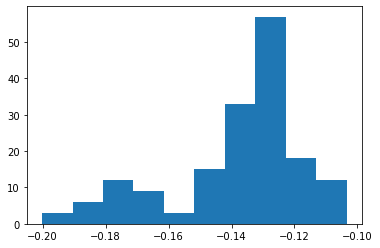

In [49]:
odds['corr'].hist(grid=False);

In [50]:
prob_hilo = []

for r in list(zip(odds['alpha_1'], odds['alpha_2'], odds['mu_1'], odds['mu_2'], odds['omega'], odds['CHL_LINE'])):
    total_count = 1. / torch.tensor(r[0:2], device='cpu') 
    logits = torch.log(torch.tensor(r[0:2], device='cpu') * torch.tensor(r[2:4], device='cpu'))
    omega = torch.tensor(r[4], device='cpu')

    bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)
    value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))
    corner = bnb_corner.log_prob(value).exp()
    
    line = r[5]
    mask = value.sum(-1) < line
    prob_lo = corner[mask].sum()
    prob_hi = 1 - prob_lo
    
    prob_hilo.append([prob_hi.item(), prob_lo.item()])

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [51]:
odds[['prob_hi', 'prob_lo']] = prob_hilo

In [52]:
odds['kelly_hi'] = (odds['prob_hi'] * odds['CHL_H'] - 1) / (odds['CHL_H'] - 1)
odds['kelly_lo'] = (odds['prob_lo'] * odds['CHL_L'] - 1) / (odds['CHL_L'] - 1)

In [53]:
odds['kelly'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], odds['kelly_hi'], odds['kelly_lo']), 
    np.nan
)

In [54]:
odds['bet'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], 'High', 'Low'), 
    None
)

In [55]:
odds = odds.sort_values('kelly', ascending=False).reset_index(drop=True)

In [56]:
odds['selected'] = np.where(
    odds['MAINLINE']==True, np.where(
        odds['kelly']>0.35, '$$$', np.where(
            odds['kelly']>0.25, '$$', np.where(
                odds['kelly']>0.15, '$', None))), 
    None
)

In [57]:
odds = odds.drop(columns=cols_pred+['kelly_hi', 'kelly_lo'])

In [58]:
odds[odds.bet.notna() & odds.selected.notna()].reset_index(drop=True)

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,SUNFB6599,2024-05-19,03:00:00,Spanish Division 1 [SFL],Alaves,Getafe,True,9.5,2.22,1.58,0.199798,0.800202,0.455722,Low,$$$
1,SATFB6585,2024-05-18,22:15:00,Spanish Division 2 [SF2],Leganes,Gijon,True,9.5,2.15,1.62,0.264832,0.735168,0.308019,Low,$$
2,MONFB6509,2024-05-20,03:00:00,French Division 1 [FFL],Toulouse,Brest,True,9.5,2.10,1.65,0.623643,0.376357,0.281501,High,$$
3,SATFB6459,2024-05-18,03:00:00,Eng Championship [ED1],Southampton,West Bromwich,True,11.5,1.95,1.75,0.313648,0.686352,0.268154,Low,$$
4,SATFB6481,2024-05-18,21:30:00,German Division 1 [GSL],Werder Bremen,Bochum,True,9.5,1.83,1.87,0.367438,0.632562,0.210220,Low,$
5,MONFB6512,2024-05-20,03:00:00,French Division 1 [FFL],Lorient,Clermont,True,9.5,2.00,1.72,0.332879,0.667121,0.204789,Low,$
6,MONFB6598,2024-05-20,01:00:00,Spanish Division 1 [SFL],Cadiz,Las Palmas,True,9.5,1.95,1.75,0.342060,0.657940,0.201861,Low,$
7,TUEFB6593,2024-05-21,02:30:00,Spanish Division 2 [SF2],Espanyol,Oviedo,True,10.5,2.20,1.59,0.299613,0.700387,0.192568,Low,$
8,SUNFB6550,2024-05-19,23:00:00,Eng Premier [EPL],Brentford,Newcastle,True,11.5,2.15,1.62,0.310610,0.689390,0.188407,Low,$
9,SUNFB6473,2024-05-19,23:00:00,Eng Premier [EPL],Crystal Palace,Aston Villa,True,11.5,2.25,1.57,0.297809,0.702191,0.179719,Low,$


In [59]:
display_df(odds[odds.MatchDay.isin(odds[odds.bet.notna() & odds.selected.notna()].MatchDay) & odds.bet.notna()])

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,SUNFB6599,2024-05-19,03:00:00,Spanish Division 1 [SFL],Alaves,Getafe,False,12.5,4.75,1.13,0.043686,0.956314,0.620271,Low,None
1,SUNFB6599,2024-05-19,03:00:00,Spanish Division 1 [SFL],Alaves,Getafe,False,10.5,2.80,1.37,0.126741,0.873259,0.530717,Low,None
2,SUNFB6599,2024-05-19,03:00:00,Spanish Division 1 [SFL],Alaves,Getafe,True,9.5,2.22,1.58,0.199798,0.800202,0.455722,Low,$$$
3,SATFB6459,2024-05-18,03:00:00,Eng Championship [ED1],Southampton,West Bromwich,False,15.5,4.75,1.13,0.067391,0.932609,0.414216,Low,None
4,SATFB6585,2024-05-18,22:15:00,Spanish Division 2 [SF2],Leganes,Gijon,False,12.5,4.75,1.13,0.068640,0.931360,0.403363,Low,None
5,SATFB6585,2024-05-18,22:15:00,Spanish Division 2 [SF2],Leganes,Gijon,False,10.5,2.70,1.39,0.177522,0.822478,0.367292,Low,None
6,SATFB6481,2024-05-18,21:30:00,German Division 1 [GSL],Werder Bremen,Bochum,False,13.5,4.75,1.13,0.074579,0.925421,0.351737,Low,None
7,SATFB6459,2024-05-18,03:00:00,Eng Championship [ED1],Southampton,West Bromwich,False,12.5,2.40,1.50,0.226676,0.773324,0.319971,Low,None
8,SATFB6585,2024-05-18,22:15:00,Spanish Division 2 [SF2],Leganes,Gijon,True,9.5,2.15,1.62,0.264832,0.735168,0.308019,Low,$$
9,MONFB6512,2024-05-20,03:00:00,French Division 1 [FFL],Lorient,Clermont,False,12.5,4.15,1.17,0.101065,0.898935,0.304436,Low,None


In [60]:
odds[odds.MAINLINE].to_csv(path_output/f'odds-{datetime.now().strftime("%Y-%m-%d")}.csv', float_format='%.2f', index=False)